<a href="https://colab.research.google.com/github/RNavs-44/Machine_Learning_Projects/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 3 Project:

*Objective: train classification system on MNIST dataset*

MNIST dataset:
* set of of 70,000 small images of handwritten digits
* each image labeled with digit it represents

In [2]:
from sklearn.datasets import fetch_openml

# sklearn provides helper functions to download popular datasets
# fetch_* functions download real-life datasets
# load_* functions load small toy datasets bundled with scikit learn
# make_* functions generate fake datasets
# contain DESCR, data and target entries
mnist = fetch_openml('mnist_784', as_frame=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
X, y = mnist.data, mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
X.shape

(70000, 784)

In [5]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [6]:
y.shape

(70000,)

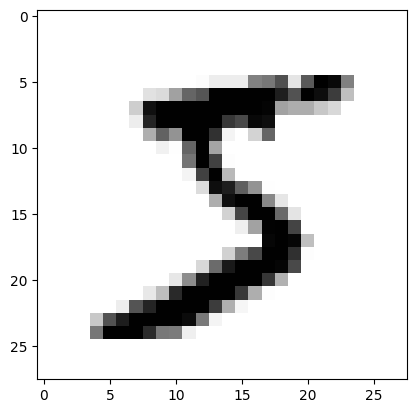

In [7]:
# each image has 784 features as it is 28 * 28 pixels
import matplotlib.pyplot as plt

def plot_digit(image_data):
  image = image_data.reshape(28, 28)
  plt.imshow(image, cmap="binary")
  plt.axis("on")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [8]:
# looks like a 5 as identified by label
y[0]

'5'

In [9]:
# MNIST dataset already split into training set and test set
# traning set already shuffled guaranteeing cross-validation folds similar
# and preventing poor algorithm performance by getting many similar instances
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training binary classifier

In [10]:
# create target vector for classification task of 5-detector
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [11]:
from sklearn.linear_model import SGDClassifier

# creating SGDClassifier and training it on whole training set
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# use SGDClassifier to detect images of number 5
sgd_clf.predict([some_digit])

array([ True])

# Performance measures

##Measuring accuracy using cross-validation

In [12]:
# c_v_s function() evaluates SGD classifier using k-fold cross-validation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.dummy import DummyClassifier

# train dummy classifier that classifier every image into most frequent class
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [14]:
# dummy classifier has over 90% accuracy, reducing impressiveness of 95%
cross_val_score(dummy_clf, X_train, y_train_5, scoring="accuracy")

array([0.90958333, 0.90966667, 0.90966667, 0.90966667, 0.90966667])

In [15]:
# implementing cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# performs stratified sampling to produce folds containing representative ratio
skfolds = StratifiedKFold(n_splits=3) # add shuffle=True if not shuffled

for train_index, test_index in skfolds.split(X_train, y_train_5):
  # creates clone of classifier
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  # trains clones on training folds and makes predictions on test fold
  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  # count number of correct predictions
  n_correct = sum(y_pred == y_test_fold)
  # output ratio of correct predictions
  print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


## Confusion matrix

In [16]:
from sklearn.model_selection import cross_val_predict

# instead of returing evaluation scores c_v_p returns predictions made
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix

# create confusion matrix
# each row represents actual class, column represents predicted class
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [18]:
# perfect classifier would have nonzero values only on main diagonal
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

##Precision and recall

In [19]:
from sklearn.metrics import precision_score, recall_score

# precision is TP / (TP + FP), recall is TP / (TP + FN)
# recall is ratio of positive instances correctly detected by classifier
precision_score(y_train_5, y_train_pred) # == 3530 / (687 + 3530)

0.8370879772350012

Convenient to combine precision and recall into a single metric, f1 score:
* is harmonic mean of precision and recall: 2 / (1/p + 1/r)
* classifier will only get high f1 score if both recall and precision high
* favours classifier with similar precision and recall but not always best
* e.g. video-filtering system would prefer classifer with low recall and high precision, as you would rather reject good videos than accept bad videos
* e.g. surveillance shoplift system would rather have low precision and high recall as although guards get few alerts, almost all shoplifters caught

In [20]:
recall_score(y_train_5, y_train_pred) # == 3530 / (1891 + 3530)

0.6511713705958311

In [21]:
from sklearn.metrics import f1_score

# convenient to combine precision and recall into single metric, f1 score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

SGD classifier computes score based on decision function for each instance
* if score > decision_threshold assigns instance to +ve class
* precision, recall tradeoff, higher threshold, higher precision, lower recall

In [22]:
# d_f() method returns score for each instance, you can use any threshold
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [23]:
threshold = 0 # threshold used by SGD classifier
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [24]:
# increasing threshold causes classifier to miss digit
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [25]:
# deciding which threshold to use
# use c_v_p() func to get scores of all instances in training set
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [26]:
from sklearn.metrics import precision_recall_curve

# use p_r_c() func to compute precision and recall for all possible thresholds
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

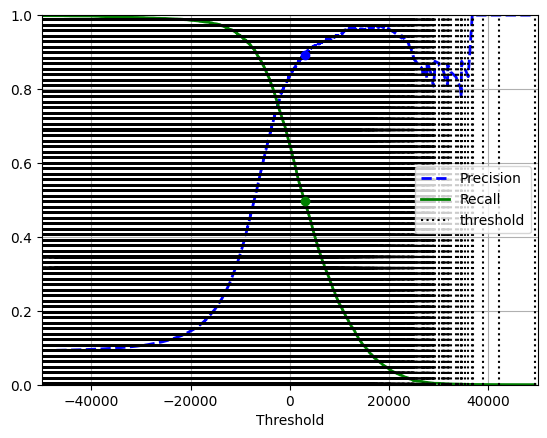

In [27]:
# plot precision and recall as functions of threshold value
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(thresholds, 0, 1.0, "k", "dotted", label="threshold")
# beautify figure
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

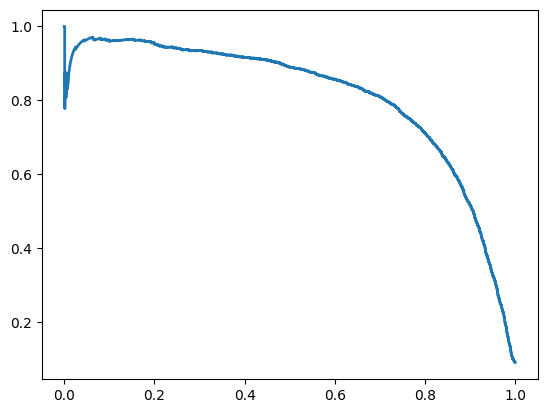

In [28]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.show()

In [29]:
# suppose you aim for 90% precision, you can search for lowest threshold
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [30]:
# to make predictions
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

# check prediction's precision and recall
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [31]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

## ROC Curve

ROC Curve:
* plots True Positive Rate (recall) vs False Positive Rate
* FPR = 1 - TNR = 1 - specifity

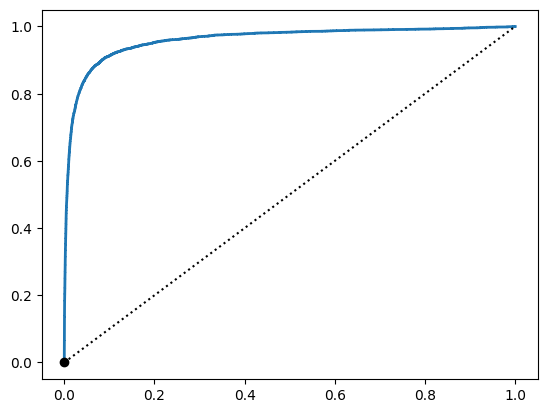

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
idx_for_threshold_at_90 = (threshold <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

# good class. stays as far away from random class., towards top-left corner
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.show()

In [33]:
from sklearn.metrics import roc_auc_score

# one way to compare class. is measure area under curve, perfect=1, random=0.5
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

ROC curve vs PR curve:
* prefer PR curve whenever positive class is rare or you care more about FP than FN
* otherwise use ROC curve
* e.g. looking at previous ROC curve, classifier looks really good but that is because there a few +ves, 5s, compared to -ves, non 5s

In [34]:
from sklearn.ensemble import RandomForestClassifier

# lets compare this class. PR curve and f1 scorve to SGD classifier
# note RFC does not have decision_function method but has predict_proba method
# which returns class probs for each instance, and we use prob of +ve class as
# score, required by precision_recall_curve function
forest_clf = RandomForestClassifier(random_state=42)

In [37]:
# train classifier using cross-validation and predict class probs for each class
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

# look at class probs for first few images in training set
y_probas_forest[:5]

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       [1.  , 0.  ],
       [0.99, 0.01]])

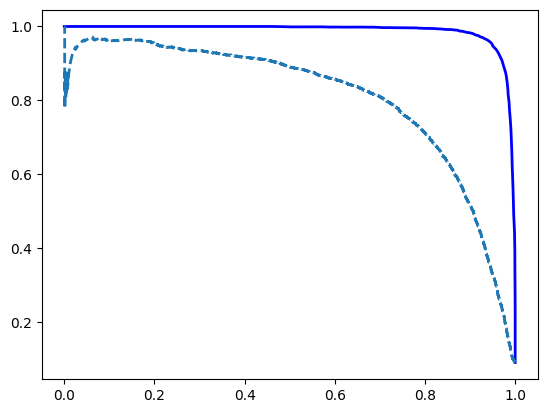

In [38]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

# plot both PR curves to compare
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.show()

In [39]:
# RFC is superior to SGD class. as its curve comes much closer to top right
# its f1 score and roc auc score also better
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [40]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [41]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [42]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

#Multiclass Classification:


Some classifiers capable of handling multiple classes natively, however, various strategies to perform multiclass classification with multiple binary classifiers

OVR:
* one versus the rest, or one versus all strategy
* train 10 binary classifiers, one for each digit
* to classify image compare scores for each classifier and pick one with highest

OVO:
* one versus one strategy
* train a binary classifier for every pair of digits
* each classifier only needs to be trained on part of training set containing 2 classes it must distinguish
* preferred for algorithms that scale poorly with size of training set

In [43]:
from sklearn.svm import SVC

# sk-learn detects when you try to use binary class. on multi class. task
# it then automatically runs OvR or OvO depending on algorithm, in this case OvO
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [44]:
# lets make prediction on an image
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [45]:
# d_f() returns 10 scores per instance, one per class
# each class gets score = no. of won duels +/- small tweak (max +-0.33)
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [46]:
# highest score 9.3, one corresponding to class 5
class_id = some_digit_scores.argmax()
class_id

5

In [47]:
# classifier stores list of target classes in classes_ attribute when trained
# in case of MNIST index of each class matches class, but not always case
svm_clf.classes_
svm_clf.classes_[class_id]

'5'

In [48]:
from sklearn.multiclass import OneVsRestClassifier

# you can force sk-learn to use OVO or OVR classifier
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [49]:
# lets make prediction
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [50]:
# check number of trained classifiers
len(ovr_clf.estimators_)

10

In [51]:
# training SGDClassifier on multiclass dataset and make predictions
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [52]:
# look at scores SGD class. assigned, clearly not very confident
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [53]:
# use c_v_s to evaluate, as same no of images in each class, accuracy metric ok
# random classifier would get 10% accuracy
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [54]:
from sklearn.preprocessing import StandardScaler

# you can still do much better and improve accuracy e.g. scale inputs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis


If you found a promising model and want to find ways to improve it you can analyse the types of errors that it makes:
* first look at confusion matrix, by making predictions using cross_val_predict() and passing labels and predictions to confusion_matrix() function

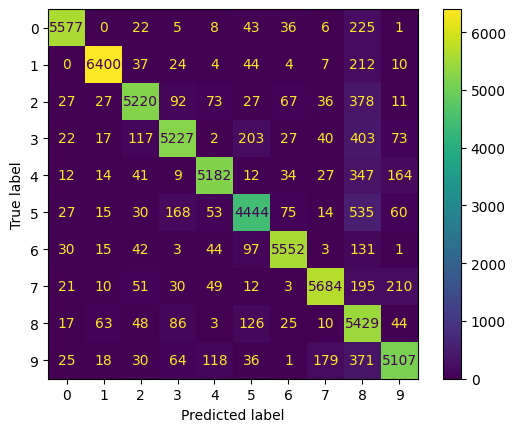

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

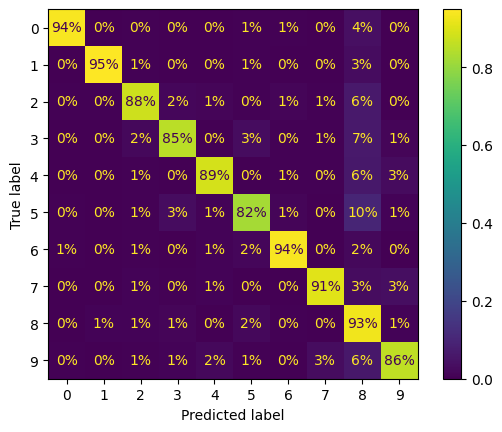

In [57]:
# must normalise dataset as low number of 5s classified correctly could be
# because model made more errors or there are less instances of 5 in dataset
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

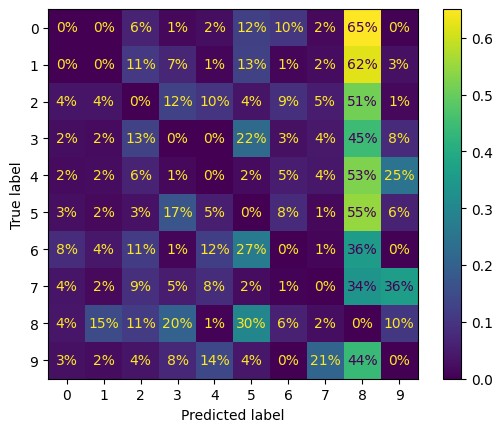

In [58]:
# to make errors stand out more you can put 0 weight on correct predictions
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

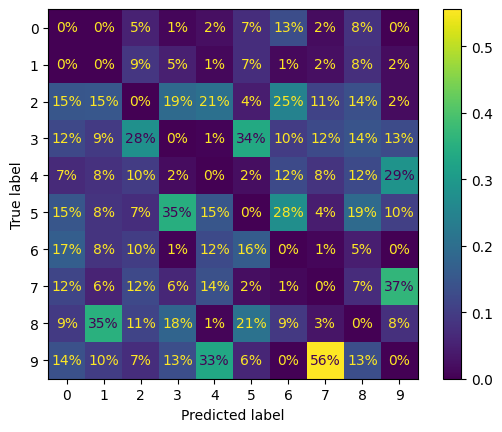

In [59]:
# you can also normalise matrix by column rather than row
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
plt.show()

In [60]:
# analysing individual errors good way to gain insights into what classifer is
# doing and why it is failing
# to fix issue augment training set with shifted and rotated variants of images
# called data augmentation
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]


# Multilabel Classification


In some cases you want classifier to output multiple classes for each instance:
* e.g. facial recognition classifier, if it recognises several people in same picture
* such a classification system that outputs multiple binary tags called multilabel classification system

In [63]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# create y_multilabel array containing 2 target labels for each digit image
y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

# create KNC which supports multilabel classification
knn_clf = KNeighborsClassifier()
# trains model using multiple targets array
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [66]:
# if you make a prediction 2 labels outputted, 5 not large and odd
knn_clf.predict([some_digit])

array([[False,  True]])

In [68]:
# many ways to evaluate multilabel class. e.g. measuring f1 score for each
# individual label and computing average score
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=2)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9735086054032637

In [70]:
# above approach assumes all labels equally important, however, if you have
# more pics of A than B or C you may want to give more weight to classifier's
# score on pics of A
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9751012382425887

In [ ]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=2, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

In [ ]:
chain_clf.predict([some_digit])

# Multioutput Classification

Generalisation of multilabel classification where each label can be multiclass


In [72]:
np.random.seed(42) # for reproducible results

# create sets by taking MNIST img and adding noise to pixel intensities
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

# target images will be original images
y_train_mod = X_train
y_test_mod = X_test

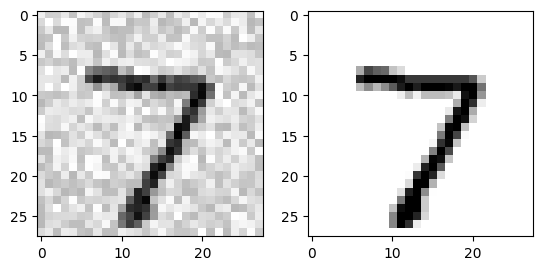

In [80]:
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
plt.show()

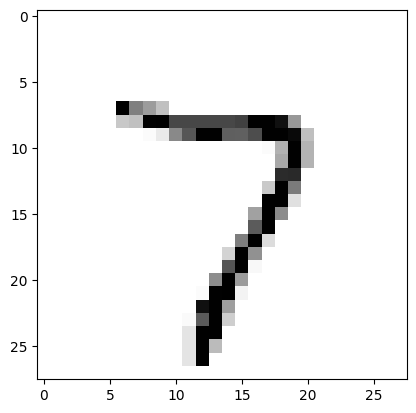

In [81]:
# train classifier and make it clean up image
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()